In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

In [53]:
# PARAMETERS 
R = 8.314
INITIAL_TEMP = 293
ATM = 1e5
LIQUID_DENSITY = 1000  # Kg / m^3
AIR_DENSITY = 1.225  # Kg / m^3
G = -9.8
G_VEC = np.array([0, G])
GAMMA = 1.4
AIR_DRAG_COEFF = .75 

In [74]:
class Simulation:
    
    def __init__(self, *, 
                 bottle_volume=None, 
                 inside_pressure=None, 
                 nozzle_area=None, 
                 launch_angle=None, 
                 rocket_mass=None,
                 fill_factor=None,
                 rocket_face_area=None):
        
        self.Vb = bottle_volume
        self.P0 = inside_pressure
        self.NA = nozzle_area
        self.launch_angle = launch_angle
        self.M = rocket_mass
        self.V0 = bottle_volume * (1-fill_factor)
        self.V_liquid = bottle_volume * (fill_factor)
        self.FA = rocket_face_area
        self.K = inside_pressure * (bottle_volume * (1-fill_factor))**GAMMA
        self.initial_speed = np.sqrt(2 * (inside_pressure - ATM) / LIQUID_DENSITY)
        self.drag_coeff = AIR_DRAG_COEFF * .5 * AIR_DENSITY * self.FA
        
        if self.V_liquid > 1:
            raise ValueError("Fill factor too high")
        
        self._run = False
        
    def run(self):
        if self._run:
            raise Exception("Already run simulation")
        
        self._calc_launch()
        self._calc_flight()
        
        self._run = True
        
        
    def _calc_launch(self):
        def water_exit_acc(t, vel):
            A = - (GAMMA * self.K * self.NA) / LIQUID_DENSITY
            B = (.5 * LIQUID_DENSITY * vel**2 + ATM)
            return A * (B / self.K)**((GAMMA+1)/GAMMA)
        
        def find_limit(vel_func):
            expected_area = self.V_liquid / self.NA
            for limit in np.linspace(0, 1, 1000):
                if integrate.quad(vel_func, 0, limit)[0] > expected_area:
                    return limit
            return np.inf
    
        r_launch_vel = integrate.solve_ivp(water_exit_acc, (0,1) , np.array([self.initial_speed]), dense_output=True)
        
        self.water_vel = np.vectorize(r_launch_vel.sol)
        self.launch_time = find_limit(self.water_vel)
        self.instant_impulse = lambda t: self.water_vel(t)**2 * self.NA * LIQUID_DENSITY
        self.launch_impulse = integrate.quad(self.instant_impulse, 0, self.launch_time)[0]
        self.launch_vel = integrate.quad(self.water_vel, 0, self.launch_time)[0]
        
    def _calc_flight(self):
        def drag_acceleration(t, vel):
            vm = np.linalg.norm(vel)
            return -(vm * self.drag_coeff / self.M) * vel + G_VEC
        
        post_launch_speed = self.launch_impulse / self.M
        initial_velocity = np.array([np.cos(self.launch_angle / 180 * np.pi), np.sin(self.launch_angle / 180 * np.pi)]) * post_launch_speed

        r_vel_traject = integrate.solve_ivp(drag_acceleration, (0,100) , initial_velocity, dense_output=True)
        self.vel_vec = np.vectorize(lambda t, axis: r_vel_traject.sol(t)[axis])
        self.vel_mod = np.vectorize(lambda t: np.linalg.norm(r_vel_traject.sol(t)))

        t = np.linspace(0, 10, 1000)

        dy = self.vel_vec(t, 1)
        y = integrate.cumtrapz(dy, t, initial=0)

        self.flight_time = t[np.argmax(y < 0)]
    
        
    def calc_water_speed(self, plot=False):
        if not self._run:
            raise Exception("no values calculated yet")
            
        t = np.linspace(0, self.launch_time, 50)
        water_speed = self.water_vel(t)
        
        if plot:
            plt.figure(figsize=(10, 10))
            plt.plot(t, water_speed)
            plt.xlabel("Time since launch (s)")
            plt.ylabel("Water Speed at nozzle (m/s)")
            plt.title(f"Water exit velocity over time (pressure={self.P0/ATM} atm, water vol={self.V_liquid * 1000} litres)", fontsize=14)
            plt.grid(linestyle="--")
        else:
            return t, water_speed
        
    def calc_water_volume(self, plot=False):
        if not self._run:
            raise Exception("no values calculated yet")
            
        t = np.linspace(0, self.launch_time, 1000)
        volume = (self.V_liquid - np.cumsum(np.hstack([[0], self.launch_vel(t[:999]) * self.NA * self.launch_time/1000])))*1000
        
        if plot:
            plt.figure(figsize=(10, 10))
            plt.plot(t, volume)
            plt.xlabel("Time since launch (s)")
            plt.ylabel("Water Volume (litres)")
            plt.title(f"Water volume over time (pressure={self.P0/ATM} atm, water vol={self.V_liquid * 1000} litres)", fontsize=14)
            plt.grid(linestyle="--")
        else:
            return t, volume
        
    def calc_rocket_thrust(self, plot=False):
        if not self._run:
            raise Exception("no values calculated yet")

        t = np.linspace(0, self.launch_time, 50)
        water_thrust = self.instant_impulse(t)
        
        if plot:
            plt.figure(figsize=(10, 10))
            plt.plot(t, water_thrust)
            plt.xlabel("Time since launch (s)")
            plt.ylabel("Thrust (n)")
            plt.title(f"Thrust over time (pressure={self.P0/ATM} atm, water vol={self.V_liquid * 1000} litres)", fontsize=14)
            plt.grid(linestyle="--")
        else:
            return t, water_thrust
            
    def calc_rocket_drag(self, plot=False):
        if not self._run:
            raise Exception("no values calculated yet")

        t = np.linspace(0, self.flight_time, 50)
        drag = self.vel_mod(t)**2*self.drag_coeff

        if plot: 
            plt.figure(figsize=(10, 10))
            plt.plot(t, drag)
            plt.xlabel("Time since launch (s)")
            plt.ylabel("Drag (n)")
            plt.title(f"Drag over time (pressure={self.P0/ATM} atm, water vol={self.V_liquid * 1000} litres)", fontsize=14)
            plt.grid(linestyle="--")
        else:
            return t, drag
        
        
    def calc_trajectory(self, plot=False):
        
        if not self._run:
            raise Exception("no values calculated yet")
            
        t = np.linspace(0, self.flight_time, 50)
        
        dx = self.vel_vec(t, 0)
        dy = self.vel_vec(t, 1)

        x = integrate.cumtrapz(dx, t, initial=0)
        y = integrate.cumtrapz(dy, t, initial=0)

        if plot:
            plt.figure(figsize=(10, 10))
            plt.plot(x, y)
            plt.xlabel("Distace (m)")
            plt.ylabel("Height (m)")
            plt.title(f"Trajectory (pressure={self.P0/ATM} atm, water vol={self.V_liquid * 1000} litres)", fontsize=14)
            plt.grid(linestyle="--")
            plt.axis("equal")
        else:
            return t, np.vstack([x, y]).T


In [75]:
s = Simulation(
    bottle_volume=2.5/1000, 
    inside_pressure=4e5,
    nozzle_area=0.01**2 * np.pi, 
    launch_angle=25, 
    rocket_mass=0.17,
    fill_factor=.4,
    rocket_face_area=0.05**2 * np.pi
)
s.run()

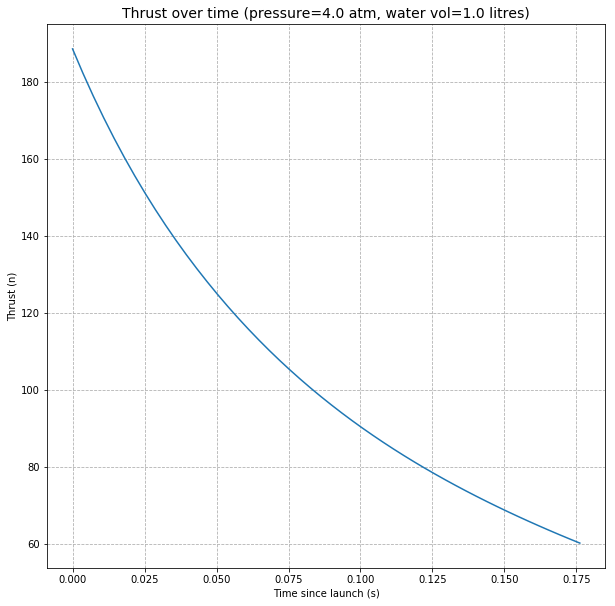

In [76]:
s.calc_rocket_thrust(plot=True)